# Task: Classification of Pnuemnoia on Chest X-Rays
 Binary Classification Problem: **To classify if a patient has Pneumonia or not by looking at their Chest X-Ray images** 

Solution: 7 Step Approach:

- Import Data

- Look at the individual cases

- Data Augmentation 

- Build the model 

- Run the model 

- Evaluate the model 

- Visualize the model history

- Generate Predictions

# Libraries Needed

In [2]:
import os
import tqdm
from os import walk

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt



# Step 1: Import Data 
Import data from directories and put them into datasets - train, val, test

In [3]:
## train, test and val folders stored as keys in an array
arr = next(os.walk('../input/chest-xray-pneumonia/chest_xray'))[1]
arr = arr[2:]


### dictionary using the above keys to form a data frame
d = {}
for i in arr:
    d[i] = next(os.walk('../input/chest-xray-pneumonia/chest_xray/'+i))[1]

for i in arr:
    target = []
    images = []
    for j in d[i]:
        files = next(os.walk('../input/chest-xray-pneumonia/chest_xray/'+i+'/'+j))[2]
        images += files
        target += [j]*len(files)
    
    d[i] = pd.DataFrame({'images':np.array(images).flatten(),'target':np.array(target).flatten()})
    

    
### Adding absolute paths to image url
for i in arr:
    d[i]['image_paths'] =  '../input/chest-xray-pneumonia/chest_xray/'+ i + '/' + d[i]['target'] + '/' + d[i]['images']
    
train = d['train']
val = d['val']
test = d['test']


### Display the dataframe
train

,images,target,image_paths
0,person1180_virus_2010.jpeg,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...
1,person1230_virus_2081.jpeg,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...
2,person1513_virus_2632.jpeg,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...
3,person124_virus_238.jpeg,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...
4,person746_virus_1369.jpeg,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...
...,...,...,...
5211,NORMAL2-IM-1160-0001.jpeg,NORMAL,../input/chest-xray-pneumonia/chest_xray/train...
5212,NORMAL2-IM-0389-0001.jpeg,NORMAL,../input/chest-xray-pneumonia/chest_xray/train...
5213,IM-0162-0001.jpeg,NORMAL,../input/chest-xray-pneumonia/chest_xray/train...
5214,NORMAL2-IM-1247-0001.jpeg,NORMAL,../input/chest-xray-pneumonia/chest_xray/train...


In [4]:
#### Small test to see if the images paths are correct and storing invalid images

l_train = []
for i in tqdm.tqdm(train['image_paths']):
    try:
        img = plt.imread(i)
    except:
        l_train.append(i)
        
l_test = []
for i in tqdm.tqdm(test['image_paths']):
    try:
        img = plt.imread(i)
    except:
        l_test.append(i)
        
l_val = []
for i in tqdm.tqdm(val['image_paths']):
    try:
        img = plt.imread(i)
    except:
        l_val.append(i)

100%|██████████| 16/16 [00:00<00:00, 66.40it/s]


In [5]:
print(l_train)
print(l_test)
print(l_val)

[]
[]
[]


In [6]:
### Shuffle the dataframe
train = train.sample(frac=1).reset_index()
train = train.drop(['index'],axis=1)
train

,images,target,image_paths
0,IM-0752-0001.jpeg,NORMAL,../input/chest-xray-pneumonia/chest_xray/train...
1,IM-0713-0001.jpeg,NORMAL,../input/chest-xray-pneumonia/chest_xray/train...
2,person330_virus_683.jpeg,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...
3,person1311_bacteria_3312.jpeg,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...
4,person637_bacteria_2528.jpeg,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...
...,...,...,...
5211,person1222_bacteria_3177.jpeg,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...
5212,person569_bacteria_2363.jpeg,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...
5213,NORMAL2-IM-0515-0001.jpeg,NORMAL,../input/chest-xray-pneumonia/chest_xray/train...
5214,person1644_bacteria_4358.jpeg,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...


# Step 2: Look at individual cases 

target: NORMAL


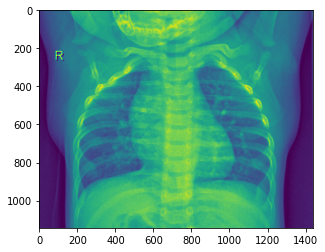

In [7]:
img = plt.imread(train['image_paths'][0])
plt.imshow(img)

print('target:' ,train['target'][0])



target: PNEUMONIA


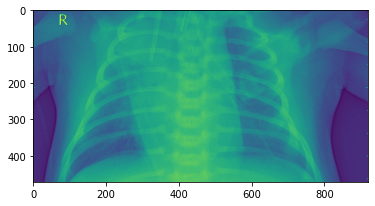

In [8]:
img = plt.imread(train['image_paths'][4])
plt.imshow(img)

print('target:' ,train['target'][4])

# Step 3: Data Augmentation 
- Create a data generators with image augmentations
- Create train, val and test augmetation generators which help data **flow from datasets** to the model

In [9]:
IMG_SIZE = 64
BATCH = 16
SEED = 42


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

In [10]:
ds_train = train_datagen.flow_from_dataframe(train,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image_paths',
                                             y_col = 'target',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val,
                                            #directory=train_path,
                                            x_col = 'image_paths',
                                            y_col = 'target',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(test,
                                            #directory=test_path,
                                            x_col = 'image_paths',
                                            y_col = 'target',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            shuffle = False)


Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


# Step 4: Build the model

In [11]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          3

# Step 5: Run the model
- Callbacks (Save the best model)
- Compile
- Fit (Run for 20 epochs)

In [12]:
### CallBacks

count = 0

### Save the best model
saved_callbacks = tf.keras.callbacks.ModelCheckpoint('./saved_models/bestmodel_'+str(count),
                                     save_weights_only=False, 
                                     monitor='val_loss', 
                                     save_best_only=True)
    
### Complie and Fit Model 
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy',])  

history = model.fit(ds_train, validation_data = ds_val, epochs=20, verbose=2,
                   callbacks=[saved_callbacks]
    )

Epoch 1/20
326/326 - 66s - loss: 0.4564 - accuracy: 0.7929 - val_loss: 0.3136 - val_accuracy: 0.8750
Epoch 2/20
326/326 - 59s - loss: 0.2233 - accuracy: 0.9139 - val_loss: 0.2365 - val_accuracy: 0.9375
Epoch 3/20
326/326 - 59s - loss: 0.1833 - accuracy: 0.9296 - val_loss: 0.2177 - val_accuracy: 0.9375
Epoch 4/20
326/326 - 59s - loss: 0.1623 - accuracy: 0.9388 - val_loss: 0.1968 - val_accuracy: 0.9375
Epoch 5/20
326/326 - 59s - loss: 0.1518 - accuracy: 0.9450 - val_loss: 0.2513 - val_accuracy: 0.9375
Epoch 6/20
326/326 - 59s - loss: 0.1457 - accuracy: 0.9419 - val_loss: 0.1690 - val_accuracy: 1.0000
Epoch 7/20
326/326 - 59s - loss: 0.1356 - accuracy: 0.9500 - val_loss: 0.3427 - val_accuracy: 0.7500
Epoch 8/20
326/326 - 59s - loss: 0.1298 - accuracy: 0.9490 - val_loss: 0.8630 - val_accuracy: 0.6250
Epoch 9/20
326/326 - 60s - loss: 0.1297 - accuracy: 0.9509 - val_loss: 0.1323 - val_accuracy: 1.0000
Epoch 10/20
326/326 - 60s - loss: 0.1233 - accuracy: 0.9546 - val_loss: 0.2880 - val_accura

# Step 6: Evaluate the Model

In [13]:
model = tf.keras.models.load_model('./saved_models/bestmodel_'+str(count))

In [14]:
model.evaluate(ds_test)

39/39 [==============================] - 6s 154ms/step - loss: 0.5240 - accuracy: 0.8381


[0.5239509344100952, 0.8381410241127014]

# Step 7: Visualize the model history

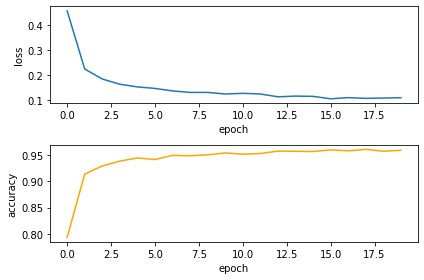

In [15]:

plt.subplot(2 ,1, 1)
a = plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')


plt.subplot(2, 1 ,2)
b = plt.plot(history.history['accuracy'],color="orange")
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.tight_layout()
plt.show()

# Step 8: Generate predictions

In [16]:
preds_sigmoid = model.predict(ds_test)

In [17]:
preds_sigmoid[:9]

array([[0.9999846 ],
       [0.96092474],
       [0.9968912 ],
       [0.9999021 ],
       [0.999931  ],
       [0.9882395 ],
       [0.9986436 ],
       [0.9997336 ],
       [0.9958365 ]], dtype=float32)

In [18]:
predicted_classes = [1 * (x[0]>=0.5) for x in preds_sigmoid]
predicted_classes[:9]

[1, 1, 1, 1, 1, 1, 1, 1, 1]